In [ ]:
# ---------------------------------------------------------
# 1. DATA AGGREGATION
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import os

df_main = pd.read_csv(os.path.join('daten', 'cleanedSelfEmployed.csv'))
df_controls = pd.read_csv(os.path.join('daten', 'cleanedLabourStats.csv'))

main_dataset = os.path.join('daten', 'aggregatedData.csv')

for df in [df_main, df_controls]:
    if not df.empty:
        df['Province'] = df['Province'].astype(str).str.strip()
        df['Sex'] = df['Sex'].astype(str).str.strip()
        df['Year'] = df['Year'].astype(int)

df = pd.merge(df_main, df_controls, on=['Province', 'Sex', 'Year'], how='left')

df['Self_Employment_Rate'] = df['Self_Employed'] / df['Control_LaborForce']

df['log_Rate'] = np.log(df['Self_Employment_Rate'])

df['Treat'] = (df['Sex'] == 'Women+').astype(int)

df['Post'] = (df['Year'] >= 2018).astype(int)

df['Treat_x_Post'] = df['Treat'] * df['Post']

df['Time_Trend'] = df['Year'] - 2014


final_cols = ['Province', 'Year', 'Sex', 'log_Rate', 'Treat', 'Post', 'Treat_x_Post', 'Control_UnemploymentRate', 'Time_Trend']

df_final = df[final_cols].dropna()

df_final.to_csv(main_dataset, index=False)

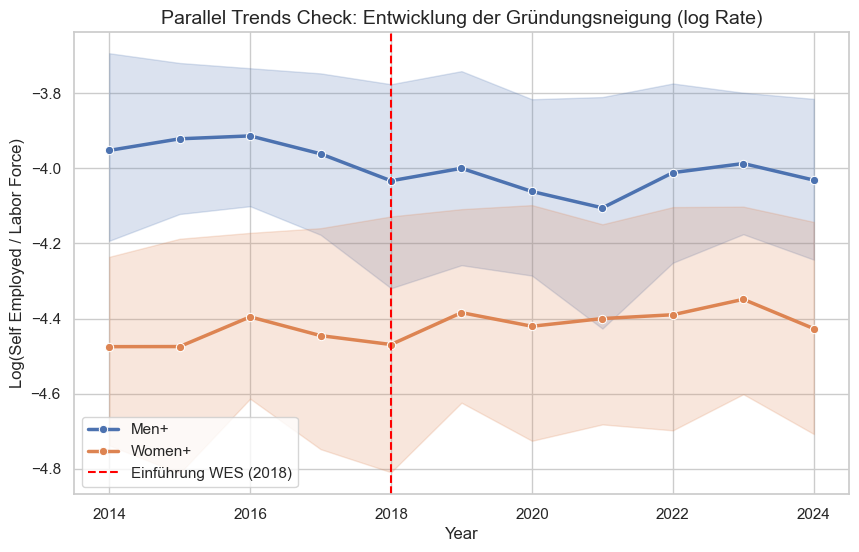

                            OLS Regression Results                            
Dep. Variable:               log_Rate   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     18.15
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           0.000371
Time:                        09:53:44   Log-Likelihood:                 40.624
No. Observations:                  80   AIC:                            -55.25
Df Residuals:                      67   BIC:                            -24.28
Df Model:                          12                                         
Covariance Type:              cluster                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

c:\Users\bscav\Documents\uniJena\seminarEntrepreneurship\seminarArbeit\venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 3
  warnings.warn('covariance of constraints does not have full '


In [6]:
# ---------------------------------------------------------
# 2. PARALLEL TRENDS
# ---------------------------------------------------------
sns.set_theme(style="whitegrid")

df_pre = df_final[df_final['Year'] < 2018].copy()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_final, x='Year', y='log_Rate', hue='Sex', marker='o', linewidth=2.5)

plt.axvline(x=2018, color='red', linestyle='--', label='Einführung WES (2018)')
plt.title('Parallel Trends Check: Entwicklung der Gründungsneigung (log Rate)', fontsize=14)
plt.ylabel('Log(Self Employed / Labor Force)')
plt.legend()
plt.savefig('parallelTrends.png', dpi=300, bbox_inches='tight')
plt.show()

model_pre = smf.ols("log_Rate ~ Treat * Time_Trend + C(Province)", data=df_pre)
res_pre = model_pre.fit(cov_type='cluster', cov_kwds={'groups': df_pre['Province']})

with open('parallelTrendsResult.txt', 'w') as f:
    f.write(res_pre.summary().as_text())

print(res_pre.summary())

p_val = res_pre.pvalues['Treat:Time_Trend']
print(f"\nSignifikanz des Trend-Unterschieds (p-Wert): {p_val:.4f}")

if p_val > 0.05:
    print("ERGEBNIS: ✓ Trends sind parallel (p > 0.05).")
else:
    print("ERGEBNIS: ⚠ Trends unterscheiden sich signifikant.")

                            OLS Regression Results                            
Dep. Variable:               log_Rate   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     81.41
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           1.53e-07
Time:                        09:58:50   Log-Likelihood:                 111.24
No. Observations:                 220   AIC:                            -176.5
Df Residuals:                     197   BIC:                            -98.43
Df Model:                          22                                         
Covariance Type:              cluster                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

c:\Users\bscav\Documents\uniJena\seminarEntrepreneurship\seminarArbeit\venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 9
  warnings.warn('covariance of constraints does not have full '


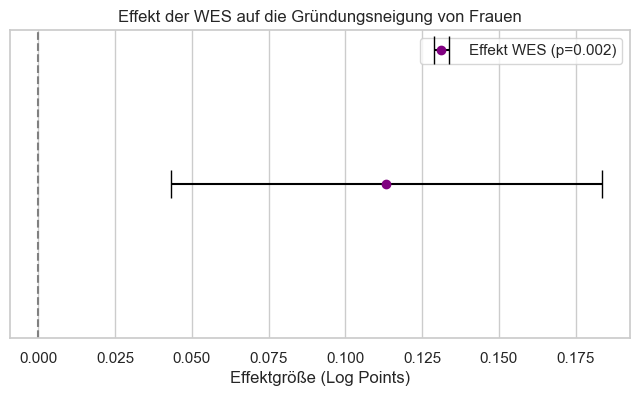

--------------------------------------------------
DiD Koeffizient: 0.1134
P-Wert:          0.00153
--------------------------------------------------


In [ ]:
# ---------------------------------------------------------
# 3. REGRESSION
# ---------------------------------------------------------
formula = """
log_Rate ~ Treat + Treat:Post + 
           Control_UnemploymentRate + 
           C(Province) + C(Year)
"""

model = smf.ols(formula=formula, data=df_final)
results = model.fit(cov_type='cluster', cov_kwds={'groups': df_final['Province']})

print(results.summary())

with open('regressionResults.txt', 'w') as f:
    f.write(results.summary().as_text())

coef = results.params['Treat:Post']
p_val = results.pvalues['Treat:Post']
conf = results.conf_int().loc['Treat:Post']

plt.figure(figsize=(8, 4))
plt.errorbar(x=coef, y=0, xerr=[[coef - conf[0]], [conf[1] - coef]], 
             fmt='o', color='purple', ecolor='black', capsize=10, 
             label=f'Effekt WES (p={p_val:.3f})')
plt.axvline(x=0, color='grey', linestyle='--')
plt.title('Effekt der WES auf die Gründungsneigung von Frauen', fontsize=12)
plt.xlabel('Effektgröße (Log Points)')
plt.yticks([])
plt.legend()
plt.savefig('DiD.png', dpi=300)
plt.show()

print("-" * 50)
print(f"DiD Koeffizient: {coef:.4f}")
print(f"P-Wert:          {p_val:.5f}")
print("-" * 50)